# US Cars Price Prediction

The goal of this project is to create a model that predicts US car prices based on known prices. The initial step involves importing all the necessary libraries.

To run the project on your computer, modify the filepath to point to the dataset.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score)
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import csv
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer
import pickle
import random
from tabulate import tabulate


file_path = 'C://Users//cerim//PythonProjectsInJupyter//CarPrediction//cars.csv'

## Data Overview

We read the dataset and display a few instances of it. There are six parameters that determine the price: brand, model, year, status, mileage, and dealer.

In [2]:
data = [] 

with open(file_path, newline='', encoding='latin-1') as csvfile:
    csv_reader = csv.reader(
        (row.replace('\0', '') for row in csvfile),
        delimiter=','
    )

    cou = 0
    for row in csv_reader:
        if cou > 0 and row!=[]:
            data.append(row)
        cou += 1
           
    df = pd.DataFrame(data, columns=['Brand', 'Model', 'Year', 'Status', 'Mileage', 'Dealer', 'Price'])

In [3]:
df.head(n=100)

,Brand,Model,Year,Status,Mileage,Dealer,Price
0,Mazda,CX-5,2023,New,,,36703.0
1,Kia,Sportage,2023,New,,Classic Kia,28990.0
2,Chevrolet,Camaro,2024,New,,Classic Chevrolet Beaumont,41425.0
3,Ford,Bronco,2023,Used,1551.0,Mike Smith Chrysler Dodge Jeep RAM,58900.0
4,Acura,TLX,2021,Used,30384.0,Mike Smith Nissan,34499.0
...,...,...,...,...,...,...,...
95,RAM,1500,2023,New,,Sterling Automotive West,51640.0
96,Jeep,Grand Cherokee,2023,New,,Sterling Automotive West,46435.0
97,GMC,Yukon,2023,New,,Beck & Masten Buick GMC South,81670.0
98,Lincoln,Navigator,2019,Used,97768.0,Beck & Masten Buick GMC South,39749.0


A brief description of the dataset. We present an overview of the dataset, illustrating the distribution of cars based on brand, year, and status parameters, as well as by price.

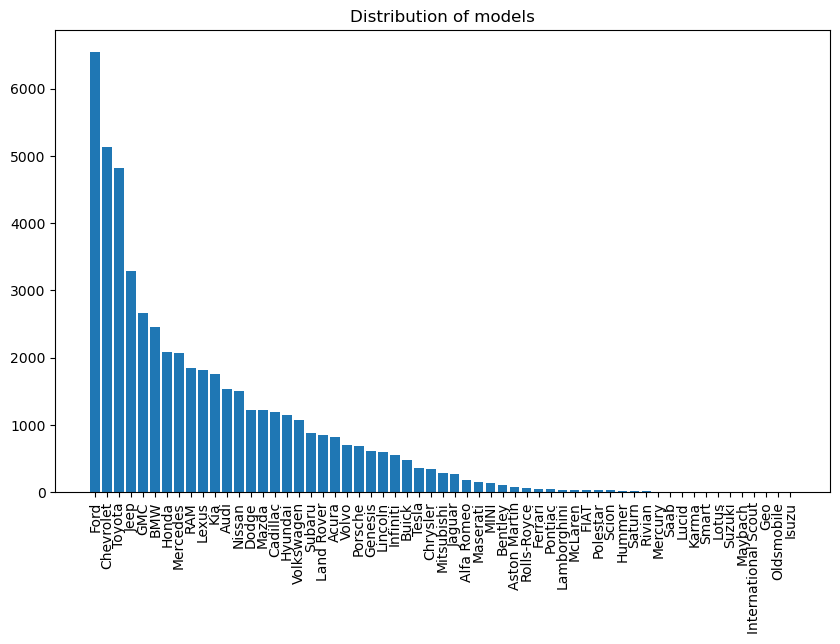

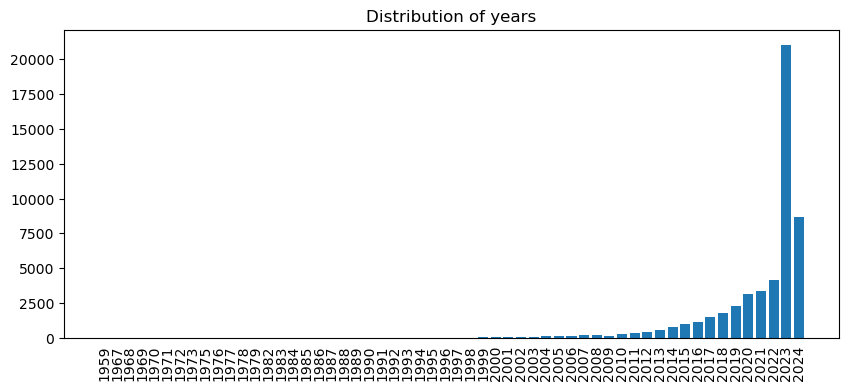

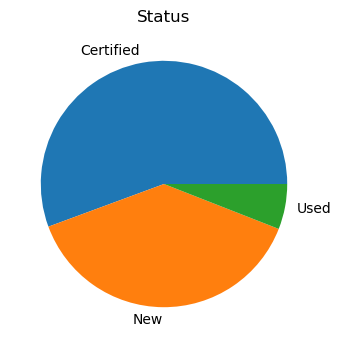

In [4]:
plt.figure(figsize=(10, 6))

plt.bar(df['Brand'].value_counts().keys(), df['Brand'].value_counts().values, width=0.8)
plt.xticks(rotation = 'vertical')
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.width'] = 0
mpl.rcParams['xtick.minor.size'] = 0
mpl.rcParams['xtick.minor.width'] = 1

plt.title('Distribution of models')


plt.figure(figsize=(10, 4))

years = list(df['Year'].value_counts().keys())
years.sort()
sorted_years = {i: df['Year'].value_counts()[i] for i in years }

plt.bar(  sorted_years.keys()  , sorted_years.values(), width=0.8)
plt.xticks(years, rotation = 'vertical')
plt.title('Distribution of years')

plt.figure(figsize=(4,4))

plt.pie( df['Status'].value_counts().values,  labels = np.unique(df['Status']))
plt.title('Status')


plt.show()


for i in range(len(df['Price'])):
    if (df['Price'][i] != ''):
        df['Price'][i] = float(df['Price'][i])
    else:
        df['Price'][i] = 0
        
    if (df['Mileage'][i] != ''):
        df['Mileage'][i] = float(df['Mileage'][i])
    else:
        df['Mileage'][i] = 0
        
    df['Year'][i] = int(df['Year'][i])

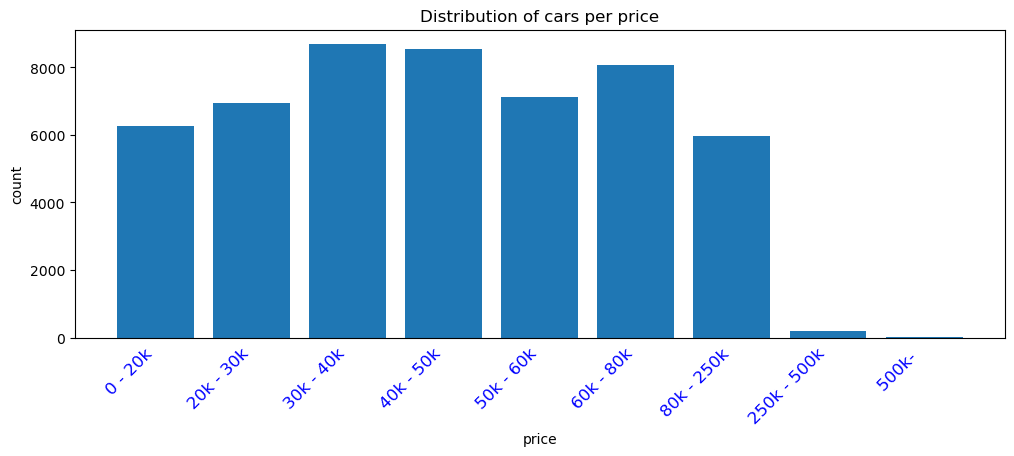

In [5]:
group = []
group.append( np.sum(df['Price'] < 20000)  )
group.append( np.sum((df['Price'] >= 20000) & (df['Price'] < 30000) ) )
group.append( np.sum((df['Price'] >= 30000) & (df['Price'] < 40000) ) )
group.append( np.sum((df['Price'] >= 40000) & (df['Price'] < 50000) ) )
group.append( np.sum((df['Price'] >= 50000) & (df['Price'] < 60000) ) )
group.append( np.sum((df['Price'] >= 60000) & (df['Price'] < 80000) ) )
group.append( np.sum((df['Price'] >= 80000) & (df['Price'] < 250000) ) )
group.append( np.sum((df['Price'] >= 250000) & (df['Price'] < 500000) ) )
group.append( np.sum(df['Price'] >= 500000) )

lab = ["0 - 20k", "20k - 30k", "30k - 40k", "40k - 50k", "50k - 60k", "60k - 80k", "80k - 250k", "250k - 500k", "500k- "]
plt.figure(figsize=(12, 4))
plt.bar ( range(len(group)) ,group, orientation = 'vertical')
plt.xticks( ticks=np.arange(len(group)) , labels = lab, rotation=45, ha='right', fontsize=12, color='blue')
plt.xlabel('price')
plt.ylabel('count')
plt.title('Distribution of cars per price')

plt.show()

We encode the parameters into numbers as it is necessary for decision trees. The mappings are stored in their corresponding dictionaries.

In [6]:
X = df.drop( columns = ['Price'] )

brand_names = sorted(df.Brand.unique())
mapper_brand_names = dict(zip(brand_names, [t for t in range(len(brand_names))]))
print (mapper_brand_names,'\n')
df["Brand"] = df["Brand"].map(mapper_brand_names)

year_names = sorted(df.Year.unique())
mapper_year_names = dict(zip(year_names, [t for t in range(len(year_names))]))
print (mapper_year_names, '\n')
df["Year"] = df["Year"].map(mapper_year_names)

status_names = sorted(df.Status.unique())
mapper_status_names = dict(zip(status_names, [t for t in range(len(status_names))]))
print (mapper_status_names, '\n')
df["Status"] = df["Status"].map(mapper_status_names)

def encode_df(dataframe):    
    le = LabelEncoder()
    for column in dataframe.columns:
        if type(dataframe[column][0] ) == str :
            dataframe[column] = le.fit_transform(dataframe[column])
    return dataframe

new_X = encode_df(X)

new_X['Year'] = new_X['Year'].astype('int')
new_X['Mileage'] = new_X['Mileage'].astype('float')

print(new_X.head())

y = df['Price']

{'Acura': 0, 'Alfa Romeo': 1, 'Aston Martin': 2, 'Audi': 3, 'BMW': 4, 'Bentley': 5, 'Buick': 6, 'Cadillac': 7, 'Chevrolet': 8, 'Chrysler': 9, 'Dodge': 10, 'FIAT': 11, 'Ferrari': 12, 'Ford': 13, 'GMC': 14, 'Genesis': 15, 'Geo': 16, 'Honda': 17, 'Hummer': 18, 'Hyundai': 19, 'Infiniti': 20, 'International Scout': 21, 'Isuzu': 22, 'Jaguar': 23, 'Jeep': 24, 'Karma': 25, 'Kia': 26, 'Lamborghini': 27, 'Land Rover': 28, 'Lexus': 29, 'Lincoln': 30, 'Lotus': 31, 'Lucid': 32, 'MINI': 33, 'Maserati': 34, 'Maybach': 35, 'Mazda': 36, 'McLaren': 37, 'Mercedes': 38, 'Mercury': 39, 'Mitsubishi': 40, 'Nissan': 41, 'Oldsmobile': 42, 'Polestar': 43, 'Pontiac': 44, 'Porsche': 45, 'RAM': 46, 'Rivian': 47, 'Rolls-Royce': 48, 'Saab': 49, 'Saturn': 50, 'Scion': 51, 'Smart': 52, 'Subaru': 53, 'Suzuki': 54, 'Tesla': 55, 'Toyota': 56, 'Volkswagen': 57, 'Volvo': 58} 

{1959: 0, 1967: 1, 1968: 2, 1969: 3, 1970: 4, 1971: 5, 1972: 6, 1973: 7, 1975: 8, 1976: 9, 1977: 10, 1978: 11, 1979: 12, 1982: 13, 1983: 14, 1984: 1

## Training the Models

We begin by splitting the data into the training and test sets.

The models under consideration are decision trees, known for their effectiveness on tabular data. The initial model we construct is an LGBM with only the num_leaves parameter set. This provides insights into feature importance.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state = 7)

clf = lgb.LGBMRegressor( metrics = 'mape' )
clf.num_leaves = 128
clf.fit(X_train, y_train.astype('float'))

print( clf.feature_importances_ )
print( clf.feature_name_)

[2417 4506 1294  163 1608 2712]
['Brand', 'Model', 'Year', 'Status', 'Mileage', 'Dealer']


Tuning the LGB Model

We perform tuning by adjusting the num_leaves and n_estimators parameters for the LGB model. Initially, no parameters are omitted.

Considering a prediction of 110k for a car with a true price of 100k as equivalent to predicting 9k for a car with a true price of 10k, we find it reasonable to use mean absolute percentage error as the metric.

In [8]:
lgb_model = lgb.LGBMRegressor()

gridParams = {
    'n_estimators': [55, 60, 65, 70, 75, 100, 500, 1000],
    'num_leaves': [200, 225, 235, 256, 275, 300]
    }
grid = GridSearchCV(lgb_model, gridParams, verbose=0, cv=4, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')

grid.fit(X_train, y_train.astype('float'), verbose = 0)

#print(grid.cv_results_)

results_df = pd.DataFrame(grid.cv_results_)
#print (results_df)

print (grid.best_score_)
best_lgb_model = grid.best_estimator_
print (best_lgb_model.get_params())

-4.272450487560272e+18
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': -1, 'num_leaves': 300, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


Tuning LGB Model. In this iteration, we perform tuning on the LGB model, excluding the 'Status' parameter as it has been identified as the least important in the previous analysis.

In [9]:
X_train_lgb_2 = X_train.drop(columns=['Status'])
X_test_lgb_2 = X_test.drop(columns=['Status'])

lgb_model = lgb.LGBMRegressor()

gridParams = {
    'n_estimators': [55, 60, 65, 70, 75, 100, 500, 1000],
    'num_leaves': [200, 225, 235, 256, 275, 300]
    }
grid = GridSearchCV(lgb_model, gridParams, verbose=0, cv=4, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')

grid.fit(X_train_lgb_2, y_train.astype('float'), verbose=0)

#print(grid.cv_results_)

results_df = pd.DataFrame(grid.cv_results_)
#print (results_df)

print (grid.best_score_)
best_lgb_2_model = grid.best_estimator_
print (best_lgb_2_model.get_params())

-4.2807427434315295e+18
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': -1, 'num_leaves': 300, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


Tuning XGB Model. We proceed to tune the XGB model with all the original parameters, focusing on the n_estimators parameter for optimization.

In [10]:
xgb_model = xgb.XGBRegressor( metrics = 'mape' )

gridParams = {
    'n_estimators': [55, 60, 65, 70, 75, 100, 500, 1000],
    }
grid = GridSearchCV(xgb_model, gridParams, verbose=0, cv=4, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')

grid.fit(X_train, y_train.astype('float'), verbose=0)

#print(grid.cv_results_)

results_df = pd.DataFrame(grid.cv_results_)
#print (results_df)

print (grid.best_score_)
best_xgb_model = grid.best_estimator_
print (best_xgb_model.get_params())

-4.3418810238903813e+18
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'metrics': 'mape'}


Tuning XGB Model. In this round of tuning, we omit a single parameter from the XGB model. After several trials, it was determined that the best result is achieved when excluding the 'Dealer' parameter.

In [11]:
X_train_xgb_2 = X_train.drop(columns=['Dealer'])
X_test_xgb_2 = X_test.drop(columns=['Dealer'])

xgb_model = xgb.XGBRegressor( metrics = 'mape' )

gridParams = {
    'n_estimators': [55, 60, 65, 70, 75, 100, 500, 1000],
    }
grid = GridSearchCV(xgb_model, gridParams, verbose=0, cv=4, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')

grid.fit(X_train_xgb_2, y_train.astype('float'), verbose=0)

#print(grid.cv_results_)

results_df = pd.DataFrame(grid.cv_results_)
#print (results_df)

print (grid.best_score_)
best_xgb_2_model = grid.best_estimator_
print (best_xgb_2_model.get_params())

-5.42490061099435e+18
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'metrics': 'mape'}


The best models so far. CatBoost was also tested but demonstrated inferior performance compared to these models.

In [12]:
print ("LGB model 1 parameters:", best_lgb_model.get_params(), '\n')
print ("LGB model 2 parameters:", best_lgb_2_model.get_params(), '\n')
print ("XGB model 1 parameters:", best_xgb_model.get_params(), '\n')
print ("XGB model 2 parameters:", best_xgb_2_model.get_params())

LGB model 1 parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': -1, 'num_leaves': 300, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 

LGB model 2 parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': -1, 'num_leaves': 300, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 

XGB model 1 parameters: {'objective': 'reg:squarederror', 'base_score': None, 'b

Advanced Tuning of LGB Model with all parameters. In this phase, we conduct advanced tuning of the LGB model by optimizing all six parameters. We employ a grid search to tune five hyperparameters, and the process is repeated five times. In each iteration, the step of the grid search is halved.

In [13]:
def mape_scorer(y_true, y_pred, epsilon=1e-10):
    absolute_percentage_error = np.abs((y_true - y_pred) / y_true )
    return np.mean(absolute_percentage_error) * 100

ind = y_train > 0

X_train = X_train[ind]
y_train = y_train[ind]

k = 0
while k < 5:
    print(k)
    
    lr_BEST = 0.08
    lr_STEP = 0.01
    
    min_child_samples_BEST = 15
    min_child_samples_STEP = 3
    
    min_child_weight_BEST = 0.0005
    min_child_weight_STEP = 0.0001
    
    n_estimators_BEST = 110
    n_estimators_STEP = 5
    
    subsample_for_bin_BEST = 150000
    subsample_for_bin_STEP = 30000
    

    param_grid = {
        'boosting_type': ['gbdt'],
        'class_weight': [None],
        'colsample_bytree': [1.0],
        'importance_type': ['split'],
        'learning_rate': [ lr_BEST - lr_STEP, lr_BEST, lr_BEST + lr_STEP ],
        'max_depth': [-1],
        'min_child_samples': [  min_child_samples_BEST - min_child_samples_STEP, min_child_samples_BEST,
                              min_child_weight_BEST + min_child_samples_STEP  ],
        'min_child_weight': [  min_child_weight_BEST - min_child_weight_STEP, min_child_samples_BEST,
                               min_child_samples_BEST + min_child_samples_STEP],
        'min_split_gain': [0.0],
        'n_estimators': [  n_estimators_BEST - n_estimators_STEP, n_estimators_BEST,
                         n_estimators_BEST + n_estimators_STEP  ],
        'n_jobs': [-1],
        'num_leaves': [  128, 256, 512  ],
        'objective': [None],
        'random_state': [None],
        'reg_alpha': [0.0],
        'reg_lambda': [0.0],
        'silent': ['warn'],
        'subsample': [1.0],
        'subsample_for_bin': [ subsample_for_bin_BEST-subsample_for_bin_STEP, subsample_for_bin_BEST,
                             subsample_for_bin_BEST + subsample_for_bin_STEP],
        'subsample_freq': [0]
    }
    
    clf = lgb.LGBMRegressor()

    grid_search = GridSearchCV(clf , param_grid, cv=4, verbose=0, scoring=make_scorer(mape_scorer, greater_is_better=False),
                              return_train_score=True)

    grid_search.fit(X_train, y_train.astype('float'), verbose=0)

    bp = grid_search.best_params_
    
    lr_BEST = bp['learning_rate']
    min_child_samples_BEST = bp['min_child_samples']
    n_estimators_BEST = bp['n_estimators']
    subsample_for_bin_BEST = bp['subsample_for_bin']
    
    lr_STEP /= 2
    min_child_samples_STEP /=2
    n_estimators_STEP /=2
    subsample_for_bin_STEP /=2
    
    best_score = -grid_search.best_score_
    
    k+=1

best_tuned_lgb = grid_search.best_estimator_

print("Best Hyperparameters:", grid_search.best_params_, '\n')
print ("LGB model score:", best_score)

scores = []
scores.append(best_score)

0
1
2
3
4
Best Hyperparameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.09, 'max_depth': -1, 'min_child_samples': 12, 'min_child_weight': 0.0004, 'min_split_gain': 0.0, 'n_estimators': 115, 'n_jobs': -1, 'num_leaves': 256, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 120000, 'subsample_freq': 0} 

LGB model score: 16.63351229929944


Advanced Tuning of LGB Model without 'Status' parameter. The method is the same as above.

In [14]:
k=0
while k < 5:
    
    print(k)
    
    lr_BEST = 0.1
    lr_STEP = 0.02
    
    min_child_samples_BEST = 20
    min_child_samples_STEP = 5
    
    min_child_weight_BEST = 0.001
    min_child_weight_STEP = 0.0005
    
    n_estimators_BEST = 60
    n_estimators_STEP = 10
    
    subsample_for_bin_BEST = 200000
    subsample_for_bin_STEP = 20000
    

    param_grid = {
        'boosting_type': ['gbdt'],
        'class_weight': [None],
        'colsample_bytree': [1.0],
        'importance_type': ['split'],
        'learning_rate': [ lr_BEST - lr_STEP, lr_BEST, lr_BEST + lr_STEP ],
        'max_depth': [-1],
        'min_child_samples': [  min_child_samples_BEST - min_child_samples_STEP, min_child_samples_BEST,
                              min_child_samples_BEST + min_child_samples_STEP  ],
        'min_child_weight': [  min_child_weight_BEST - min_child_weight_STEP, min_child_weight_BEST,
                               min_child_weight_BEST + min_child_weight_STEP],
        'min_split_gain': [0.0],
        'n_estimators': [  n_estimators_BEST - n_estimators_STEP, n_estimators_BEST,
                         n_estimators_BEST + n_estimators_STEP  ],
        'n_jobs': [-1],
        'num_leaves': [  128, 256, 512  ],
        'objective': [None],
        'random_state': [None],
        'reg_alpha': [0.0],
        'reg_lambda': [0.0],
        'silent': ['warn'],
        'subsample': [1.0],
        'subsample_for_bin': [ subsample_for_bin_BEST-subsample_for_bin_STEP, subsample_for_bin_BEST,
                             subsample_for_bin_BEST + subsample_for_bin_STEP],
        'subsample_freq': [0]
    }

    grid_search = GridSearchCV( best_lgb_2_model , param_grid, cv=4, verbose=0, scoring=make_scorer(mape_scorer, greater_is_better=False),
                              return_train_score=True)

    grid_search.fit(X_train.drop(columns=['Status']) , y_train.astype('float'), verbose=0)

    bp = grid_search.best_params_
    
    lr_BEST = bp['learning_rate']
    min_child_samples_BEST = bp['min_child_samples']
    n_estimators_BEST = bp['n_estimators']
    subsample_for_bin_BEST = bp['subsample_for_bin']
    
    lr_STEP /= 2
    min_child_samples_STEP /=2
    n_estimators_STEP /=2
    subsample_for_bin_STEP /=2
    
    best_score = -grid_search.best_score_
    
    k+=1
    
best_tuned_lgb_2 = grid_search.best_estimator_

print("Best Hyperparameters:", grid_search.best_params_, '\n')
print ("LGB model score:", best_score)
scores.append(best_score)

0
1
2
3
4
Best Hyperparameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.12000000000000001, 'max_depth': -1, 'min_child_samples': 15, 'min_child_weight': 0.0005, 'min_split_gain': 0.0, 'n_estimators': 70, 'n_jobs': -1, 'num_leaves': 256, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 180000, 'subsample_freq': 0} 

LGB model score: 17.00209913095872


Advanced tuning of the XGB model with all parameters, employing the same method.

In [15]:
print( best_xgb_model.get_params()  )

k=0
while k < 5:
    
    print(k)
    
    n_estimators_STEP = n_estimators_BEST / 5

    param_grid = {
        'num_leaves': [  128, 256, 512  ],
        'subsample_for_bin': [ subsample_for_bin_BEST-subsample_for_bin_STEP, subsample_for_bin_BEST,
                             subsample_for_bin_BEST + subsample_for_bin_STEP]
    }

    grid_search = GridSearchCV( best_xgb_model , param_grid, cv=4, verbose=0, scoring=make_scorer(mape_scorer, greater_is_better=False),
                              return_train_score=True)

    grid_search.fit(X_train, y_train.astype('float'), verbose=0)

    bp = grid_search.best_params_
    
    print("Best Hyperparameters:", bp)
    print("Best MAPE Score:", -grid_search.best_score_)

    subsample_for_bin_BEST = bp['subsample_for_bin']
    
    subsample_for_bin_STEP /=2
    
    best_score = -grid_search.best_score_
    
    k+=1

best_tuned_xgb = grid_search.best_estimator_

print("Best Hyperparameters:", grid_search.best_params_, '\n')
print ("XGB model score:", best_score)
scores.append(best_score)

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'metrics': 'mape'}
0
Best Hyperparameters: {'num_leaves': 128, 'subsample_for_bin': 170000.0}
Best 

Advanced tuning of XGB model without 'Dealer' as parameter using the same method.

In [16]:
print( best_xgb_2_model.get_params()  )

k=0
while k < 5:
    
    print(k)
    
    n_estimators_STEP = n_estimators_BEST / 5
    

    param_grid = {
        'n_estimators': [  n_estimators_BEST - n_estimators_STEP, n_estimators_BEST,
                         n_estimators_BEST + n_estimators_STEP  ],
        'num_leaves': [  128, 256, 512  ],
    }

    grid_search = GridSearchCV( best_xgb_2_model , param_grid, cv=4, verbose=0, scoring=make_scorer(mape_scorer, greater_is_better=False),
                              return_train_score=True)

    grid_search.fit(X_train, y_train.astype('float'), verbose=0)

    bp = grid_search.best_params_
    
    print("Best Hyperparameters:", bp)
    print("Best MAPE Score:", -grid_search.best_score_)

    n_estimators_BEST = bp['n_estimators']
    
    n_estimators_STEP /=2
    
    best_score = -grid_search.best_score_
    
    k+=1
    
best_tuned_xgb_2 = grid_search.best_estimator_

print("Best Hyperparameters:", grid_search.best_params_, '\n')
print ("XGB model 2 score:", best_score)
scores.append(best_score)

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'metrics': 'mape'}
0
Best Hyperparameters: {'n_estimators': 70, 'num_leaves': 128}
Best MAPE Score:

Saving the best tuned model for each of the 4 types

Among the four types of models, the LGBM with all parameters utilized has achieved the best score. We are now saving the best-tuned model for each type.

In [17]:
pickle.dump(best_tuned_lgb, open("best_tuned_lgb.sav", 'wb'))
pickle.dump(best_tuned_lgb_2, open("best_tuned_lgb_2.sav", 'wb'))
pickle.dump(best_tuned_xgb, open("best_tuned_xgb.sav", 'wb'))
pickle.dump(best_tuned_xgb_2, open("best_tuned_xgb_2.sav", 'wb'))

table = [  ['LGBM 1', 'LGBM 2', 'XGB 1', 'XGB 2']  , 
         [ round(scores[0], 4) , round ( scores[1], 4), round(scores[2], 4), round(scores[3], 4 ) ]  ]  
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤══════════╤═════════╤═════════╕
│   LGBM 1 │   LGBM 2 │   XGB 1 │   XGB 2 │
╞══════════╪══════════╪═════════╪═════════╡
│  16.6335 │  17.0021 │ 17.5449 │ 17.9864 │
╘══════════╧══════════╧═════════╧═════════╛


## Results Overview
Pairing the indices of the test set with corresponding errors is needed for further analysis.

Here are the errors on the test set. Additionally, we present instances with the greatest and smallest errors.

In [18]:
model = pickle.load( open( "best_tuned_lgb.sav", 'rb') )

y_pred = model.predict(X_test)
y_true = y_test.values

ind = y_true > 0
X_test = X_test[ind]
y_pred = y_pred[ind]
y_true = y_true[ind]

errors = abs( (y_pred - y_true) / y_true  )
ind = range(len(errors))
zipped = zip (errors, ind)

print('Best model parameters:\n')
table = [  ['learning rate', 'min_child_samples', 'min_child_weight',
           'n_estimators', 'num_leaves', 'subsample_for_bin']  , [0.09, 12, 0.0004, 115, 256, 120000]  ]  
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

test_score = round( np.average(errors), 6 ) * 100

print ( '\nBest model scores:\n' )
table = [  ['Train MAPE', 'Test MAPE'],  [ round(scores[0], 4),  round(test_score, 4)  ]  ]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

zipped = sorted(zipped, key=lambda x: x[0])
zipped = np.flip(zipped)
zipped = [[zipped[i][1], zipped[i][0]] for i in range(len(zipped))]

first_row = X_test.iloc[0]
last_row = X_test.iloc[-1]

last = (int)(zipped[len(zipped) - 1][1])
first = (int)(zipped[0][1])

extremes = pd.DataFrame([first_row, last_row])

extremes['Price'] = [    y_true[ first ]   ,    y_true[ last ]   ]
extremes['Prediction'] = [   y_pred[ first ]   ,    y_pred[ last ]  ]
extremes['Error'] = [zipped[0][0], zipped[len(zipped) - 1][0]]

def inv_brand(ind):
    for br in mapper_brand_names.keys():
        if mapper_brand_names[br] == ind:
            return br
        
def inv_year(ind):
    for y in mapper_year_names.keys():
        if mapper_year_names[y] == ind:
            return y
        
def inv_status(ind):
    for st in mapper_status_names.keys():
        if mapper_status_names[st] == ind:
            return st

extremes['Year'] = extremes['Year'].apply ( inv_year ) 
extremes['Brand'] = extremes['Brand'].apply ( inv_brand )
extremes['Status'] = extremes['Status'].apply ( inv_status )

extremes.head()

Best model parameters:

╒═════════════════╤═════════════════════╤════════════════════╤════════════════╤══════════════╤═════════════════════╕
│   learning rate │   min_child_samples │   min_child_weight │   n_estimators │   num_leaves │   subsample_for_bin │
╞═════════════════╪═════════════════════╪════════════════════╪════════════════╪══════════════╪═════════════════════╡
│            0.09 │                  12 │             0.0004 │            115 │          256 │              120000 │
╘═════════════════╧═════════════════════╧════════════════════╧════════════════╧══════════════╧═════════════════════╛

Best model scores:

╒══════════════╤═════════════╕
│   Train MAPE │   Test MAPE │
╞══════════════╪═════════════╡
│      16.6335 │     16.3418 │
╘══════════════╧═════════════╛


,Brand,Model,Year,Status,Mileage,Dealer,Price,Prediction,Error
31250,Land Rover,411.0,None,New,0.0,4003.0,3480.0,80158.197579,22.033965
10791,GMC,463.0,None,Used,105861.0,2273.0,44520.0,44520.222270,0.000005


This function takes a dataframe and the name of one of its columns as parameters. For each unique value in the specified column, the function collects all the indices of the dataframe where that value is present in the column. The result is returned as a dictionary with values from the column as keys and lists of corresponding indices as values.

In [19]:
def dict_of_indices(arg, df):
    dict = globals()["mapper_" + arg.lower() + "_names"]
    
    diffs = dict.keys()
    
    indices = {}
    for value in diffs:
        ind = []
        for i in range(len(df)):
            if (arg.lower() == "year"):
                if df[arg].values[i] == value:
                    ind.append(i)
            elif df[arg].values[i] == dict[value]:
                ind.append(i)
            
        indices[value] = ind
        
    return indices

The function below expects a dataframe and the name of one of its columns as parameters. It calculates and displays the average error for each unique value of the specified column.

In [20]:
def avg_mape(arg, df):

    loc_dict = dict_of_indices(arg, df)
    sol = {}
        
    mapper = globals()["mapper_"+arg.lower()+"_names"]

    for key in loc_dict.keys():
        indices = loc_dict[key]

        sum = 0
        for i in range(len(zipped)):
            if zipped[i][1] in indices:
                sum += zipped[i][0]        
        
        if (len(indices) != 0):
            sol[key] = sum/len(indices)
        else:
            sol[key] = 0

    plt.figure(figsize=(12, 4))
    plt.bar( np.arange(len(sol.keys() )), sol.values(), width=0.8)

    plt.xticks(  np.arange(len(sol.keys())), mapper.keys() , rotation='vertical' )
    plt.show()

The average error for each brand, year and status.

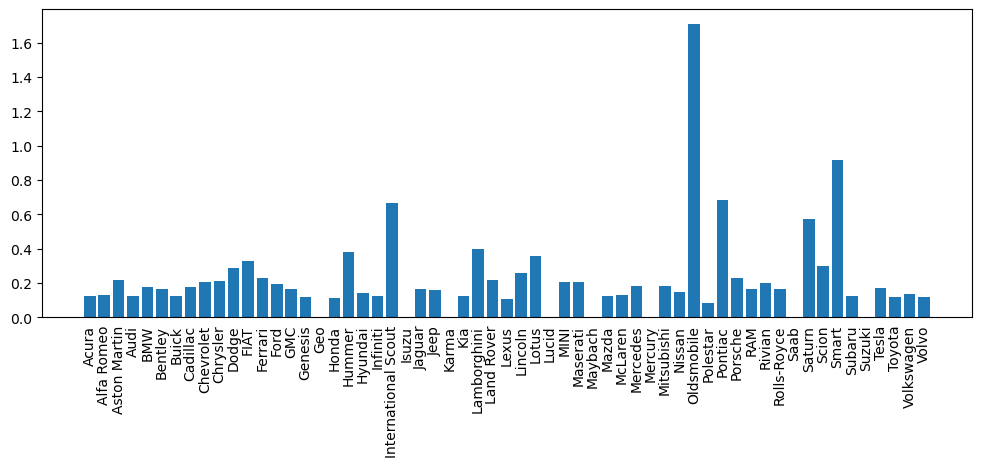

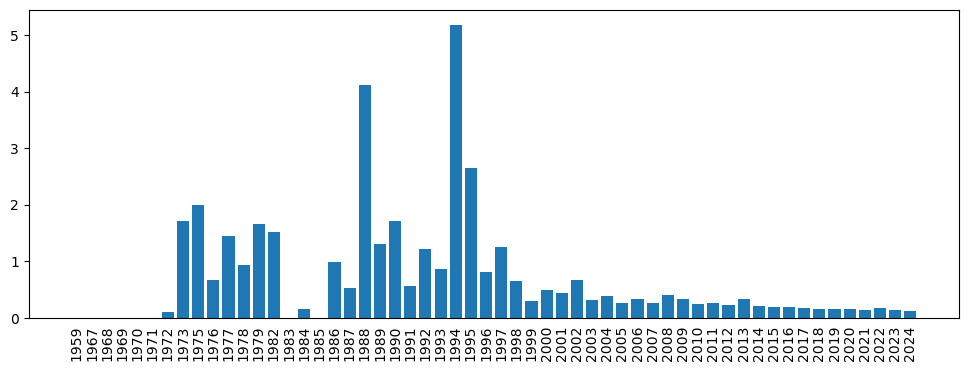

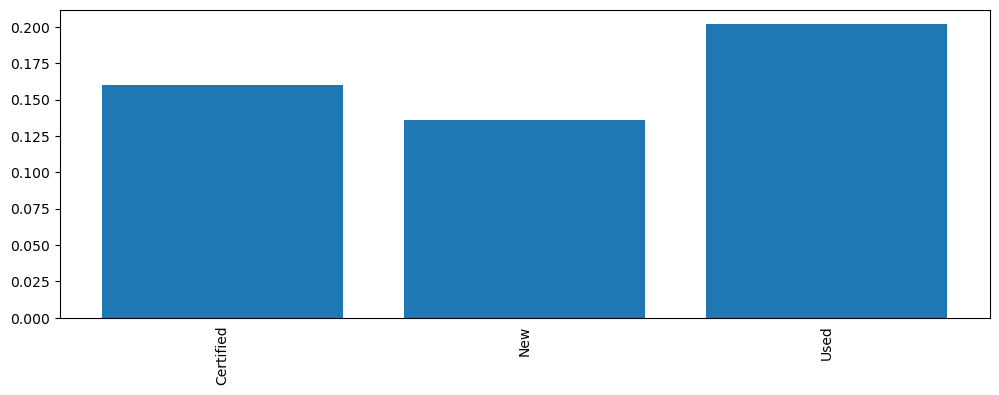

In [21]:
avg_mape('Brand', X_test)
avg_mape('Year', X_test)
avg_mape('Status', X_test)

Comparing the true and predicted price for 20 random instances of the test set.

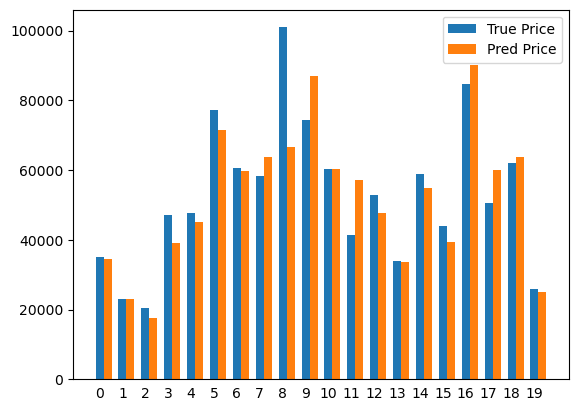

In [22]:
samp = random.sample (range(len(X_test)), 20)

bar_width = 0.35
bar_positions1 = np.arange(20)
bar_positions2 = bar_positions1 + bar_width

plt.bar(bar_positions1, y_true[samp], width=bar_width, label='True Price')
plt.bar(bar_positions2, y_pred[samp], width=bar_width, label='Pred Price')
plt.xticks(np.arange(len(samp)), range(len(samp)))

plt.legend()
plt.show()

Comparing the true and predicted price for a random instance of each brand.

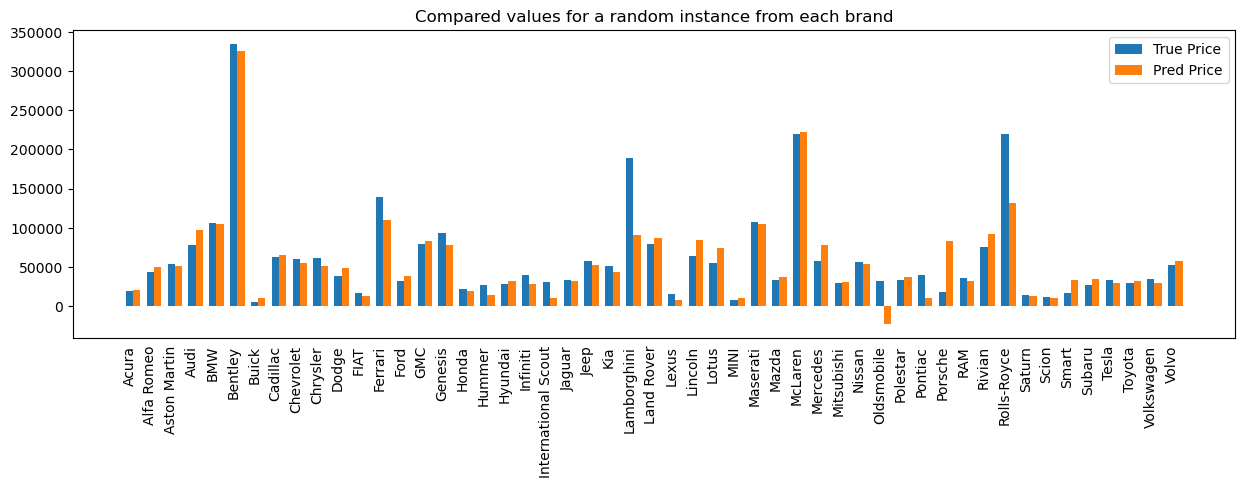

In [23]:
def get_one_sample(group):
    return group.sample(1)

result_df = X_test.groupby('Brand', group_keys=False).apply(get_one_sample)
one_from_each = result_df.index

brand_ind = result_df.Brand

lab=[]
for bi in brand_ind:
    for key in mapper_brand_names.keys():
        if (mapper_brand_names[key] == bi):
            lab.append(key)

bar_width = 0.35
bar_positions1 = np.arange(len(one_from_each))
bar_positions2 = bar_positions1 + bar_width

indices = [  X_test.index.get_loc(i) for i in one_from_each ]       

plt.figure(figsize=(15, 4))
plt.bar(bar_positions1, y_true[indices], width=bar_width, label='True Price')
plt.bar(bar_positions2, y_pred[indices], width=bar_width, label='Pred Price')
plt.xticks(  ticks = range(len(one_from_each))  , labels=lab, rotation = 'vertical' )

plt.title('Compared values for a random instance from each brand')
plt.legend()
plt.show()